In [1]:
!pip install gym gym[atari]

In [348]:
!pip install baselines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.3/123.3 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 36.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 19.0 MB/s eta 0:00:00
  Created wheel for baselines: filename=baselines-0.1.5-py3-none-any.whl size=163872 sha256=fed24e5fb84ff328483b93ba07150a19ec27d6d637c124c1dd208fe85c79cd66
  Stored in directory: /root/.cache/pip/wheels/15/3f/02/08a044ee7137c180bcb1310fd065931b5046b6dcb2a21ba9ec
  Created wheel for mpi4py: filen

In [349]:
import gym
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import numpy as np
os.environ["SDL_VIDEODRIVER"] = "dummy"
from gymnasium.wrappers.monitoring import video_recorder
from baselines.common import atari_wrappers

In [343]:
env = gym.make("BreakoutNoFrameskip-v4", render_mode='rgb_array')

In [344]:
before_training = "before_training.mp4"

video = video_recorder.VideoRecorder(env, before_training)

# returns an initial observation
env.reset()
for i in range(200):
  env.render()
  video.capture_frame()
  observation, reward, done, info, _ = env.step(env.action_space.sample())

video.close()
env.close()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Moviepy - Building video before_training.mp4.
Moviepy - Writing video before_training.mp4



Moviepy - Done !
Moviepy - video ready before_training.mp4


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
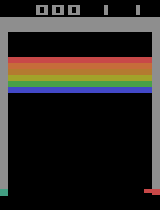

In [8]:
observation

## Start with preprocessing states

In [144]:
from gym.core import ObservationWrapper
from torchvision.transforms.functional import resize
from torchvision.transforms.functional import crop
# will use this built-in class

In [322]:
class Preprocessing(ObservationWrapper):
  def __init__(self, env):
    super().__init__(env)

    self.image_size = (64, 64)
    self._gray_scale_rule = torch.tensor([[0.8, 0.1, 0.1]], dtype=torch.float32).to(device).T.unsqueeze(1)

  def _gray_scale(self, img):
    return torch.matmul(img, self._gray_scale_rule.reshape(-1, 1))

  def observation(self, img):
        img = torch.tensor(img, dtype=torch.float32).to(device)
        img = self._gray_scale(img).squeeze(-1)
        img = img[30:200, 6:154].unsqueeze(0)
        img = resize(img, size=self.image_size) / 255
        return img



In [285]:
p = Preprocessing(env)

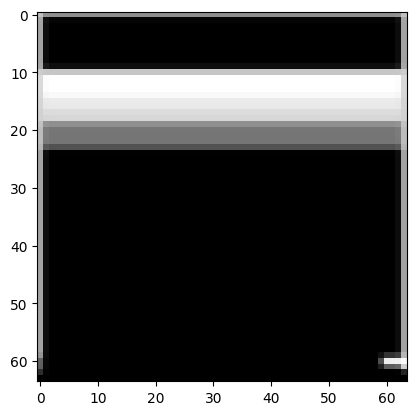

In [286]:
plt.imshow(p.process(observation)[0], cmap='gray')

## Now incorporate some rules:

In [377]:
# code from openai/baselines but remaked due to version of gym

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, info, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, info, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs, info

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info, _ = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info, _

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs, info = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, info, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs, info

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info, _ = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info, _

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)


In [388]:
from gym.wrappers import FrameStack

def AtariWrap(env, clip_rewards=True):
    assert 'NoFrameskip' in env.spec.id

    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)
    env = MaxAndSkipEnv(env, skip=2)
    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are givern by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = EpisodicLifeEnv(env)
    # This wrapper laucnhes the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can but learning would take longer.
    env = FireResetEnv(env)
    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = ClipRewardEnv(env)
    # This wrapper is yours :)
    env = Preprocessing(env)
    env = FrameStack(env, 4)

    return env

## Create a DeepLearning model which will get a sequence of 4 frames

In [315]:
class Agent(nn.Module):
  def __init__(self, n_actions):
    super().__init__()

    self.conv1 = nn.Conv2d(4, 16, kernel_size=(3, 3), stride=2)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=2)
    self.relu2 = nn.ReLU()
    self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=2)
    self.relu3 = nn.ReLU()

    self.bottleneck = nn.Flatten()

    self.linear1 = nn.Linear(3136, 256)
    self.relu4 = nn.ReLU()
    self.linear2 = nn.Linear(256, n_actions)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.conv3(x)
    x = self.relu3(x)
    print(x.shape)
    x = self.bottleneck(x)
    print(x.shape)

    x = self.linear1(x)
    x = self.relu4(x)
    x = self.linear2(x)
    return x




In [318]:
model = Agent(env.action_space.n)

In [319]:
from torchsummary import summary
summary(model, input_size=(4, 64, 64))

torch.Size([2, 64, 7, 7])
torch.Size([2, 3136])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 31, 31]             592
              ReLU-2           [-1, 16, 31, 31]               0
            Conv2d-3           [-1, 32, 15, 15]           4,640
              ReLU-4           [-1, 32, 15, 15]               0
            Conv2d-5             [-1, 64, 7, 7]          18,496
              ReLU-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                  [-1, 256]         803,072
              ReLU-9                  [-1, 256]               0
           Linear-10                    [-1, 4]           1,028
Total params: 827,828
Trainable params: 827,828
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass si